In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Load the data
file_path = '/content/drive/My Drive/Thesis/Subject2.xlsx'
cgm_data = pd.read_excel(file_path, sheet_name='CGM')

In [3]:
# Preprocess - Round to nearest 5 minutes
cgm_data['date'] = pd.to_datetime(cgm_data['date']).dt.round('5min')

# Filter out rows where mg/dl is > 400 or missing values
cgm_data = cgm_data[cgm_data['mg/dl'] <= 400].dropna(subset=['mg/dl'])

# Drop duplicates and sort
cgm_data = cgm_data.drop_duplicates(subset='date').reset_index(drop=True)
cgm_data = cgm_data.sort_values(by='date').reset_index(drop=True)

In [4]:
# Generate AR Features (using past 12 readings as input)
num_lags = 12 # Using the past 12 values
for lag in range(1, num_lags + 1):
    cgm_data[f'lag_{lag}'] = cgm_data['mg/dl'].shift(lag)

cgm_data = cgm_data.dropna().reset_index(drop=True)

In [5]:
# Create labels for prediction (15, 30, 45, 60 mins into the future)
forecast_horizon = 3  # 15 minutes (3 readings ahead assuming 5-min intervals)
cgm_data['target'] = cgm_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN due to shifting
cgm_data = cgm_data.dropna().reset_index(drop=True)

# Split into features and labels
X = cgm_data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
y = cgm_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test (80% train, 20% test by time order)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

Feed Forward Neural Network with Only Blood Glucose

In [6]:
# Build the neural network model
model = Sequential([
    Dense(64, activation='relu', input_dim=num_lags),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
8800/8800 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 4044.8750 - mae: 40.7378 - val_loss: 487.5611 - val_mae: 15.4425
Epoch 2/5
8800/8800 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 1021.8397 - mae: 23.7234 - val_loss: 409.7808 - val_mae: 14.0115
Epoch 3/5
8800/8800 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 918.0893 - mae: 22.3987 - val_loss: 376.9124 - val_mae: 13.4118
Epoch 4/5
8800/8800 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 854.6364 - mae: 21.4977 - val_loss: 365.8623 - val_mae: 13.1532
Epoch 5/5
8800/8800 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 813.6679 - mae: 20.9734 - val_loss: 368.1039 - val_mae: 13.2072
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 554.7319 - mae: 16.3615
Test Loss: 604.695556640625, Test MAE: 16.881488800048828
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [7]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 24.590562298947024


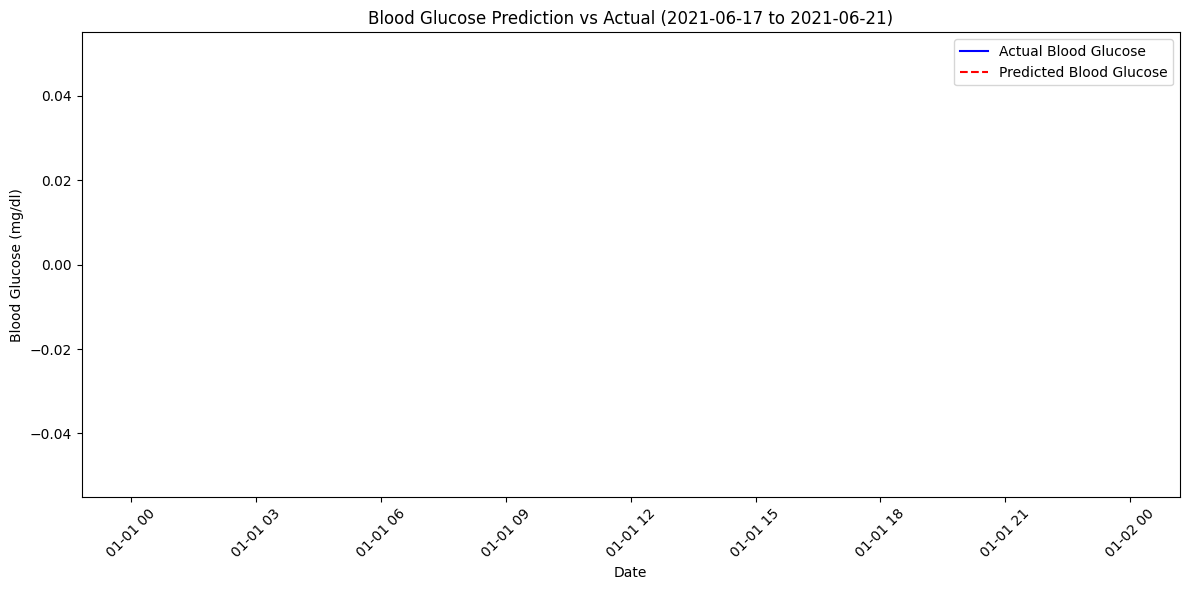

In [8]:
import matplotlib.pyplot as plt

# Add 'date' to the test data for plotting
test_dates = cgm_data['date'][train_size:].reset_index(drop=True)

# Function to plot actual vs predicted values for a specific week
def plot_predictions_for_week(test_dates, y_test, predictions, start_date, end_date):
    # Create a DataFrame for easier manipulation
    results = pd.DataFrame({
        'date': test_dates,
        'actual': y_test,
        'predicted': predictions.flatten()
    })

    # Filter data for the given date range
    week_data = results[(results['date'] >= start_date) & (results['date'] <= end_date)]

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(week_data['date'], week_data['actual'], label='Actual Blood Glucose', color='blue')
    plt.plot(week_data['date'], week_data['predicted'], label='Predicted Blood Glucose', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Blood Glucose (mg/dl)')
    plt.title(f'Blood Glucose Prediction vs Actual ({start_date} to {end_date})')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Specify the start and end date for the week
start_date = '2021-06-17'
end_date = '2021-06-21'

# Plot predictions for the specified week
plot_predictions_for_week(test_dates, y_test, predictions, start_date, end_date)


6

In [9]:
# Create labels for prediction (15, 30, 45, 60 mins into the future)
forecast_horizon = 6  # 15 minutes (3 readings ahead assuming 5-min intervals)
cgm_data['target'] = cgm_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN due to shifting
cgm_data = cgm_data.dropna().reset_index(drop=True)

# Split into features and labels
X = cgm_data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
y = cgm_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test (80% train, 20% test by time order)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [10]:
# Build the neural network model
model = Sequential([
    Dense(64, activation='relu', input_dim=num_lags),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8800/8800 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 4588.3965 - mae: 46.1473 - val_loss: 1048.6215 - val_mae: 23.2100
Epoch 2/5
8800/8800 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 1632.7288 - mae: 30.1856 - val_loss: 970.9639 - val_mae: 22.2394
Epoch 3/5
8800/8800 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 1531.9215 - mae: 29.0962 - val_loss: 965.1136 - val_mae: 22.0558
Epoch 4/5
8800/8800 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - loss: 1477.8807 - mae: 28.4163 - val_loss: 980.3685 - val_mae: 22.2288
Epoch 5/5
8800/8800 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 1427.3094 - mae: 27.8299 - val_loss: 895.2237 - val_mae: 21.3363
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1348.2195 - mae: 26.2682
Test Loss: 1408.7236328125, Test MAE: 26.78888511657715
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [11]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 37.53298116154608


9

In [12]:
# Create labels for prediction (15, 30, 45, 60 mins into the future)
forecast_horizon = 9  # 15 minutes (3 readings ahead assuming 5-min intervals)
cgm_data['target'] = cgm_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN due to shifting
cgm_data = cgm_data.dropna().reset_index(drop=True)

# Split into features and labels
X = cgm_data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
y = cgm_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test (80% train, 20% test by time order)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [13]:
# Build the neural network model
model = Sequential([
    Dense(64, activation='relu', input_dim=num_lags),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8800/8800 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 5630.1626 - mae: 53.4240 - val_loss: 1606.1886 - val_mae: 29.5600
Epoch 2/5
8800/8800 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 2489.5723 - mae: 37.7183 - val_loss: 1541.4729 - val_mae: 28.8509
Epoch 3/5
8800/8800 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 2299.6292 - mae: 36.0869 - val_loss: 1492.1705 - val_mae: 28.5347
Epoch 4/5
8800/8800 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 2187.9827 - mae: 35.0413 - val_loss: 1535.0385 - val_mae: 28.4898
Epoch 5/5
8800/8800 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - loss: 2127.6943 - mae: 34.4554 - val_loss: 1459.4105 - val_mae: 27.8993
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 2227.5537 - mae: 34.6064
Test Loss: 2348.269775390625, Test MAE: 35.566558837890625
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [14]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 48.4589403630137


12

In [15]:
# Create labels for prediction (15, 30, 45, 60 mins into the future)
forecast_horizon = 12  # 15 minutes (3 readings ahead assuming 5-min intervals)
cgm_data['target'] = cgm_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN due to shifting
cgm_data = cgm_data.dropna().reset_index(drop=True)

# Split into features and labels
X = cgm_data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
y = cgm_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test (80% train, 20% test by time order)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [16]:
# Build the neural network model
model = Sequential([
    Dense(64, activation='relu', input_dim=num_lags),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8800/8800 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 5763.3188 - mae: 54.7163 - val_loss: 2058.4282 - val_mae: 34.1923
Epoch 2/5
8800/8800 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 2875.9546 - mae: 40.7300 - val_loss: 2053.0901 - val_mae: 33.8001
Epoch 3/5
8800/8800 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: 2778.6868 - mae: 39.9365 - val_loss: 2022.5966 - val_mae: 33.5388
Epoch 4/5
8800/8800 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 2715.9463 - mae: 39.4164 - val_loss: 1981.5925 - val_mae: 33.1779
Epoch 5/5
8800/8800 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - loss: 2662.5879 - mae: 38.9236 - val_loss: 1957.1555 - val_mae: 33.0397
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 3001.3347 - mae: 41.0156
Test Loss: 3146.607421875, Test MAE: 41.942230224609375
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


In [17]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 56.09462820782871


Feed Forward Neural Network with Blood Glucose and Bolus

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import mean_squared_error

# Load CGM and Bolus data
file_path = '/content/drive/My Drive/Thesis/Subject1.xlsx'
cgm_data = pd.read_excel(file_path, sheet_name='CGM')
bolus_data = pd.read_excel(file_path, sheet_name='Bolus')

In [19]:
# Preprocess CGM data
cgm_data['date'] = pd.to_datetime(cgm_data['date']).dt.round('5min')
cgm_data = cgm_data[cgm_data['mg/dl'] <= 400].dropna(subset=['mg/dl'])
cgm_data = cgm_data.drop_duplicates(subset='date').sort_values(by='date').reset_index(drop=True)

# Preprocess Bolus data
bolus_data['date'] = pd.to_datetime(bolus_data['date']).dt.round('5min')
bolus_data = bolus_data.fillna(0)  # Set missing values to 0

# Merge CGM and Bolus data
merged_data = pd.merge(cgm_data, bolus_data, on='date', how='left').fillna(0)

# Generate lag features for CGM (past glucose readings)
num_lags = 12  # Number of past readings to use
for lag in range(1, num_lags + 1):
    merged_data[f'lag_{lag}'] = merged_data['mg/dl'].shift(lag)

# Generate lag features for Bolus variables
bolus_vars = ['normal', 'carbInput', 'insulinCarbRatio', 'bgInput', 'recommended.carb',
              'recommended.net', 'recommended.correction', 'insulinSensitivityFactor',
              'targetBloodGlucose', 'insulinOnBoard']

for var in bolus_vars:
    for lag in range(1, num_lags + 1):
        merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)

<ipython-input-19-b23c5d981a10>:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)
<ipython-input-19-b23c5d981a10>:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)
<ipython-input-19-b23c5d981a10>:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

In [20]:
# Generate target variable (15-minute ahead glucose levels)
forecast_horizon = 3  # Predict 15 minutes ahead
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaNs introduced by lagging and shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Define features (X) and target (y)
feature_columns = [col for col in merged_data.columns if 'lag' in col]
X = merged_data[feature_columns].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test (80% train, 20% test by time order)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

<ipython-input-20-2e8ff43a49a4>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)


In [21]:
# Build the neural network model
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Add a function to plot actual vs predicted
import matplotlib.pyplot as plt

test_dates = merged_data['date'][train_size:].reset_index(drop=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 3472.1267 - mae: 38.1520 - val_loss: 452.3270 - val_mae: 14.5011
Epoch 2/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - loss: 1106.0470 - mae: 24.6426 - val_loss: 442.7234 - val_mae: 14.4763
Epoch 3/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 1039.5427 - mae: 23.7430 - val_loss: 432.8825 - val_mae: 14.1945
Epoch 4/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - loss: 1002.7539 - mae: 23.2456 - val_loss: 423.9394 - val_mae: 14.0046
Epoch 5/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 946.3716 - mae: 22.5435 - val_loss: 432.0376 - val_mae: 14.3790
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 381.3563 - mae: 13.6835
Test Loss: 379.43707275390625, Test MAE: 13.586174964904785
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Root Mean Squared Error (RMSE): 19.479151723478456


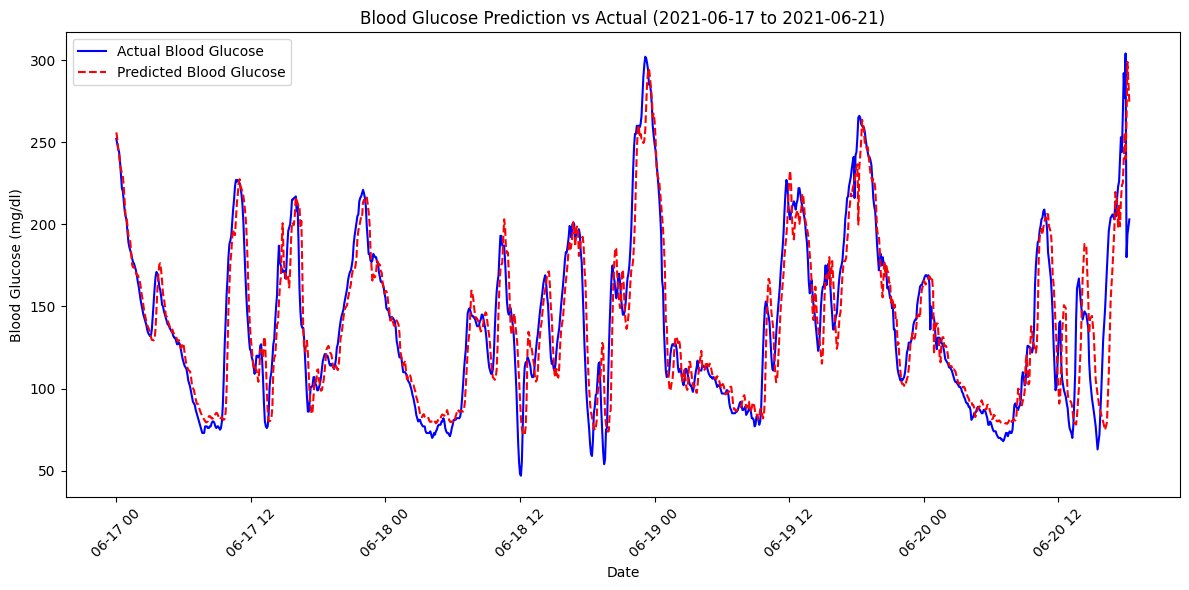

In [22]:
def plot_predictions_for_week(test_dates, y_test, predictions, start_date, end_date):
    results = pd.DataFrame({
        'date': test_dates,
        'actual': y_test,
        'predicted': predictions.flatten()
    })

    week_data = results[(results['date'] >= start_date) & (results['date'] <= end_date)]

    plt.figure(figsize=(12, 6))
    plt.plot(week_data['date'], week_data['actual'], label='Actual Blood Glucose', color='blue')
    plt.plot(week_data['date'], week_data['predicted'], label='Predicted Blood Glucose', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Blood Glucose (mg/dl)')
    plt.title(f'Blood Glucose Prediction vs Actual ({start_date} to {end_date})')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Specify dates for a week
start_date = '2021-06-17'
end_date = '2021-06-21'

# Plot predictions
plot_predictions_for_week(test_dates, y_test, predictions, start_date, end_date)

6

In [23]:
# Generate target variable (15-minute ahead glucose levels)
forecast_horizon = 6  # Predict 15 minutes ahead
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaNs introduced by lagging and shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Define features (X) and target (y)
feature_columns = [col for col in merged_data.columns if 'lag' in col]
X = merged_data[feature_columns].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test (80% train, 20% test by time order)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [24]:
# Build the neural network model
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Add a function to plot actual vs predicted
import matplotlib.pyplot as plt

test_dates = merged_data['date'][train_size:].reset_index(drop=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - loss: 3858.6218 - mae: 41.7790 - val_loss: 1007.8287 - val_mae: 22.5362
Epoch 2/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 1526.3125 - mae: 29.1552 - val_loss: 930.5073 - val_mae: 21.6468
Epoch 3/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 1461.9620 - mae: 28.3503 - val_loss: 926.3145 - val_mae: 21.3184
Epoch 4/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 1417.5059 - mae: 27.9020 - val_loss: 902.4312 - val_mae: 21.2438
Epoch 5/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 1391.1106 - mae: 27.5746 - val_loss: 890.6620 - val_mae: 20.9878
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 814.4843 - mae: 20.3341
Test Loss: 828.1019897460938, Test MAE: 20.629343032836914
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Root Mean Squared Error (RMSE): 28.77677743329072


9

In [25]:
# Generate target variable (15-minute ahead glucose levels)
forecast_horizon = 9  # Predict 15 minutes ahead
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaNs introduced by lagging and shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Define features (X) and target (y)
feature_columns = [col for col in merged_data.columns if 'lag' in col]
X = merged_data[feature_columns].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test (80% train, 20% test by time order)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [26]:
# Build the neural network model
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Add a function to plot actual vs predicted
import matplotlib.pyplot as plt

test_dates = merged_data['date'][train_size:].reset_index(drop=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 4194.4697 - mae: 45.1732 - val_loss: 1630.3934 - val_mae: 29.6835
Epoch 2/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 2063.0840 - mae: 34.2028 - val_loss: 1518.5156 - val_mae: 28.3591
Epoch 3/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 1998.5256 - mae: 33.5713 - val_loss: 1525.9385 - val_mae: 28.4957
Epoch 4/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - loss: 1977.0808 - mae: 33.3587 - val_loss: 1637.3513 - val_mae: 29.9232
Epoch 5/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 1933.2742 - mae: 32.9141 - val_loss: 1548.4865 - val_mae: 28.8550
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 1406.4879 - mae: 27.5142
Test Loss: 1376.600341796875, Test MAE: 27.21109390258789
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Root Mean Squared Error (RMSE): 37.10255858090725


12

In [27]:
# Generate target variable (15-minute ahead glucose levels)
forecast_horizon = 12  # Predict 15 minutes ahead
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaNs introduced by lagging and shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Define features (X) and target (y)
feature_columns = [col for col in merged_data.columns if 'lag' in col]
X = merged_data[feature_columns].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test (80% train, 20% test by time order)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [28]:
# Build the neural network model
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Add a function to plot actual vs predicted
import matplotlib.pyplot as plt

test_dates = merged_data['date'][train_size:].reset_index(drop=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 5183.9224 - mae: 52.0405 - val_loss: 2182.9556 - val_mae: 35.2472
Epoch 2/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - loss: 2799.8262 - mae: 40.5275 - val_loss: 2093.6113 - val_mae: 34.2503
Epoch 3/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 46s 3ms/step - loss: 2740.0161 - mae: 39.9864 - val_loss: 2059.7739 - val_mae: 33.9251
Epoch 4/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - loss: 2680.4412 - mae: 39.4407 - val_loss: 2026.1329 - val_mae: 33.6252
Epoch 5/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 2640.4087 - mae: 39.0637 - val_loss: 2164.9329 - val_mae: 34.9332
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1957.1270 - mae: 33.1071
Test Loss: 1854.331298828125, Test MAE: 32.10465621948242
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Root Mean Squared Error (RMSE): 43.061948366230986


LSTM with Blood Glucose and Bolus Data

In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load CGM and Bolus data (same preprocessing steps as before)
file_path = '/content/drive/My Drive/Thesis/Subject1.xlsx'
cgm_data = pd.read_excel(file_path, sheet_name='CGM')
bolus_data = pd.read_excel(file_path, sheet_name='Bolus')

# Preprocess CGM data
cgm_data['date'] = pd.to_datetime(cgm_data['date']).dt.round('5min')
cgm_data = cgm_data[cgm_data['mg/dl'] <= 400].dropna(subset=['mg/dl'])
cgm_data = cgm_data.drop_duplicates(subset='date').sort_values(by='date').reset_index(drop=True)

# Preprocess Bolus data
bolus_data['date'] = pd.to_datetime(bolus_data['date']).dt.round('5min')
bolus_data = bolus_data.fillna(0)

# Merge CGM and Bolus data
merged_data = pd.merge(cgm_data, bolus_data, on='date', how='left').fillna(0)

# Generate lag features for CGM and Bolus variables
num_lags = 12
for lag in range(1, num_lags + 1):
    merged_data[f'lag_{lag}'] = merged_data['mg/dl'].shift(lag)

bolus_vars = ['normal', 'carbInput', 'insulinCarbRatio', 'bgInput', 'recommended.carb',
              'recommended.net', 'recommended.correction', 'insulinSensitivityFactor',
              'targetBloodGlucose', 'insulinOnBoard']

for var in bolus_vars:
    for lag in range(1, num_lags + 1):
        merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)



<ipython-input-29-e2667385971b>:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)
<ipython-input-29-e2667385971b>:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)
<ipython-input-29-e2667385971b>:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

In [30]:
# Generate target variable
forecast_horizon = 3
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN
merged_data = merged_data.dropna().reset_index(drop=True)

# Define features and labels
feature_columns = [col for col in merged_data.columns if 'lag' in col]
X = merged_data[feature_columns].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Reshape input data for LSTM
X = X.reshape((X.shape[0], num_lags, int(X.shape[1] / num_lags)))

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

<ipython-input-30-4728be9a6491>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)


In [31]:
# Build LSTM model
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 163s 18ms/step - loss: 18986.9570 - mae: 115.3920 - val_loss: 1822.9590 - val_mae: 29.7492
Epoch 2/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 163s 18ms/step - loss: 1213.8496 - mae: 24.0967 - val_loss: 505.8681 - val_mae: 16.3275
Epoch 3/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 159s 18ms/step - loss: 757.2146 - mae: 19.8736 - val_loss: 423.5743 - val_mae: 14.1518
Epoch 4/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 198s 18ms/step - loss: 716.5914 - mae: 19.3737 - val_loss: 411.2351 - val_mae: 13.8236
Epoch 5/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 196s 17ms/step - loss: 696.7195 - mae: 19.0006 - val_loss: 432.7007 - val_mae: 14.3632
Epoch 6/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 145s 16ms/step - loss: 687.5438 - mae: 18.8614 - val_loss: 383.3079 - val_mae: 13.0674
Epoch 7/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 207s 17ms/step - loss: 678.7426 - mae: 18.7369 - val_loss: 374.3636 - val_mae: 12.8671
Epoch 8/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 153s 17ms/step - loss: 668.9811 - mae: 18.5616 - v

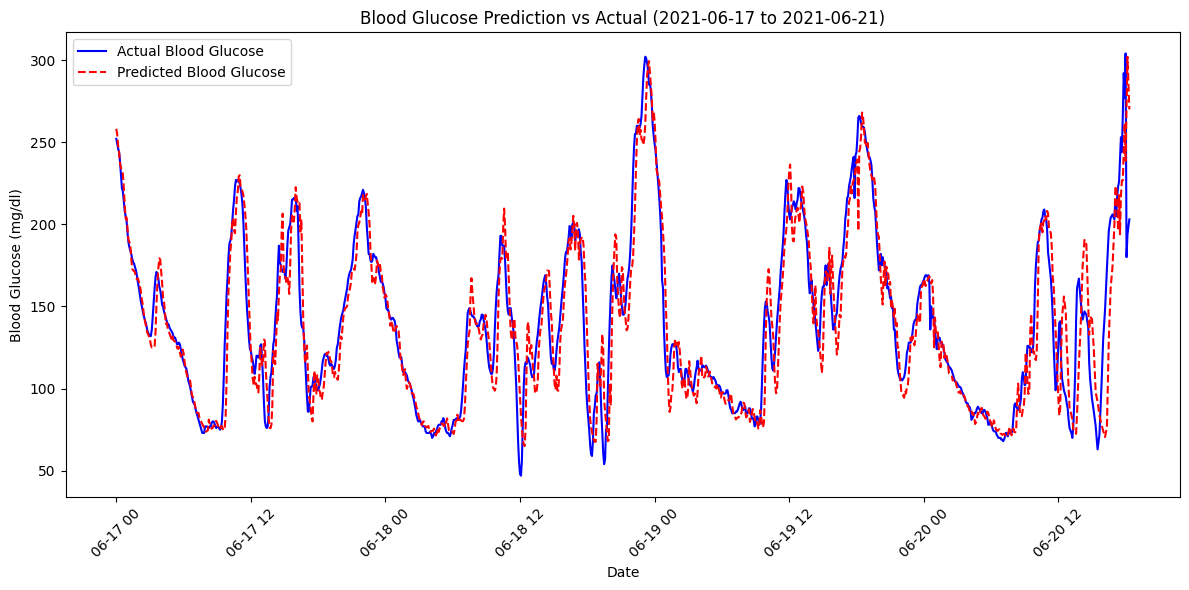

In [32]:
# Plot predictions vs actual for a given week
test_dates = merged_data['date'][train_size:].reset_index(drop=True)

def plot_predictions_for_week(test_dates, y_test, predictions, start_date, end_date):
    results = pd.DataFrame({
        'date': test_dates,
        'actual': y_test,
        'predicted': predictions.flatten()
    })

    week_data = results[(results['date'] >= start_date) & (results['date'] <= end_date)]

    plt.figure(figsize=(12, 6))
    plt.plot(week_data['date'], week_data['actual'], label='Actual Blood Glucose', color='blue')
    plt.plot(week_data['date'], week_data['predicted'], label='Predicted Blood Glucose', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Blood Glucose (mg/dl)')
    plt.title(f'Blood Glucose Prediction vs Actual ({start_date} to {end_date})')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Specify dates for a week
start_date = '2021-06-17'
end_date = '2021-06-21'

# Plot predictions
plot_predictions_for_week(test_dates, y_test, predictions, start_date, end_date)

6

In [33]:
# Generate target variable
forecast_horizon = 6
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN
merged_data = merged_data.dropna().reset_index(drop=True)

# Define features and labels
feature_columns = [col for col in merged_data.columns if 'lag' in col]
X = merged_data[feature_columns].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Reshape input data for LSTM
X = X.reshape((X.shape[0], num_lags, int(X.shape[1] / num_lags)))

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [34]:
# Build LSTM model
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 155s 17ms/step - loss: 18534.9922 - mae: 113.6311 - val_loss: 2080.6797 - val_mae: 32.9128
Epoch 2/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 199s 17ms/step - loss: 1624.6750 - mae: 29.3101 - val_loss: 957.6229 - val_mae: 21.7329
Epoch 3/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 151s 17ms/step - loss: 1233.9043 - mae: 25.8273 - val_loss: 937.5508 - val_mae: 21.9204
Epoch 4/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 197s 17ms/step - loss: 1207.4546 - mae: 25.4940 - val_loss: 887.3129 - val_mae: 20.5018
Epoch 5/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 200s 16ms/step - loss: 1178.6262 - mae: 25.1630 - val_loss: 870.2171 - val_mae: 20.2949
Epoch 6/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 150s 17ms/step - loss: 1173.2183 - mae: 25.0735 - val_loss: 852.9426 - val_mae: 20.3906
Epoch 7/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 199s 17ms/step - loss: 1153.4419 - mae: 24.8529 - val_loss: 916.4268 - val_mae: 21.5098
Epoch 8/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 148s 17ms/step - loss: 1151.6907 - mae: 24.74

9

In [35]:
# Generate target variable
forecast_horizon = 9
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN
merged_data = merged_data.dropna().reset_index(drop=True)

# Define features and labels
feature_columns = [col for col in merged_data.columns if 'lag' in col]
X = merged_data[feature_columns].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Reshape input data for LSTM
X = X.reshape((X.shape[0], num_lags, int(X.shape[1] / num_lags)))

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [36]:
# Build LSTM model
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 157s 17ms/step - loss: 18564.9375 - mae: 113.9760 - val_loss: 2602.1482 - val_mae: 37.0710
Epoch 2/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 198s 17ms/step - loss: 2149.3296 - mae: 34.6040 - val_loss: 1517.4646 - val_mae: 28.3461
Epoch 3/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 203s 17ms/step - loss: 1799.7120 - mae: 31.6852 - val_loss: 1469.4592 - val_mae: 28.0884
Epoch 4/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 204s 17ms/step - loss: 1751.8575 - mae: 31.2083 - val_loss: 1448.0809 - val_mae: 27.8974
Epoch 5/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 203s 17ms/step - loss: 1719.3778 - mae: 30.8498 - val_loss: 1522.1896 - val_mae: 28.2158
Epoch 6/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 200s 17ms/step - loss: 1709.7245 - mae: 30.7301 - val_loss: 1500.4504 - val_mae: 29.1805
Epoch 7/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 154s 17ms/step - loss: 1695.6843 - mae: 30.6112 - val_loss: 1474.6351 - val_mae: 27.9666
Epoch 8/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 151s 17ms/step - loss: 1690.8938 - mae:

12

In [37]:
# Generate target variable
forecast_horizon = 12
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN
merged_data = merged_data.dropna().reset_index(drop=True)

# Define features and labels
feature_columns = [col for col in merged_data.columns if 'lag' in col]
X = merged_data[feature_columns].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Reshape input data for LSTM
X = X.reshape((X.shape[0], num_lags, int(X.shape[1] / num_lags)))

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [38]:
# Build LSTM model
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 155s 17ms/step - loss: 18684.5098 - mae: 114.6292 - val_loss: 3144.1604 - val_mae: 42.1473
Epoch 2/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 200s 17ms/step - loss: 2620.3359 - mae: 38.9576 - val_loss: 2214.8733 - val_mae: 35.4149
Epoch 3/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 147s 17ms/step - loss: 2282.1052 - mae: 36.2229 - val_loss: 2213.6938 - val_mae: 35.4483
Epoch 4/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 148s 17ms/step - loss: 2254.5300 - mae: 35.9453 - val_loss: 1982.7347 - val_mae: 33.1256
Epoch 5/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 153s 17ms/step - loss: 2235.7517 - mae: 35.6375 - val_loss: 2022.8237 - val_mae: 33.5109
Epoch 6/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 216s 19ms/step - loss: 2199.4729 - mae: 35.3414 - val_loss: 1966.5303 - val_mae: 32.8790
Epoch 7/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 166s 19ms/step - loss: 2204.2063 - mae: 35.4125 - val_loss: 1946.9910 - val_mae: 33.0104
Epoch 8/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 192s 18ms/step - loss: 2205.7217 - mae:

CNN

In [39]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
import matplotlib.pyplot as plt

# Load CGM data
file_path = '/content/drive/My Drive/Thesis/Subject1.xlsx'
cgm_data = pd.read_excel(file_path, sheet_name='CGM')

# Preprocess CGM data - Round to nearest 5 minutes and filter
cgm_data['date'] = pd.to_datetime(cgm_data['date']).dt.round('5min')
cgm_data = cgm_data[cgm_data['mg/dl'] <= 400].dropna(subset=['mg/dl'])
cgm_data = cgm_data.drop_duplicates(subset='date').sort_values(by='date').reset_index(drop=True)

# Generate lag features for CGM data
num_lags = 12  # Using the past 12 readings as features
for lag in range(1, num_lags + 1):
    cgm_data[f'lag_{lag}'] = cgm_data['mg/dl'].shift(lag)

# Load Bolus data
bolus_data = pd.read_excel(file_path, sheet_name='Bolus')
bolus_data['date'] = pd.to_datetime(bolus_data['date']).dt.round('5min')
bolus_data = bolus_data.fillna(0)  # Set missing values to 0

# Merge CGM and Bolus data
merged_data = pd.merge(cgm_data, bolus_data, on='date', how='left').fillna(0)

# Generate lag features for Bolus variables
bolus_vars = ['normal', 'carbInput', 'insulinCarbRatio', 'bgInput',
              'recommended.carb', 'recommended.net', 'recommended.correction',
              'insulinSensitivityFactor', 'targetBloodGlucose', 'insulinOnBoard']

for var in bolus_vars:
    for lag in range(1, num_lags + 1):
        merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)

# Drop rows with NaN due to shifting
merged_data = merged_data.dropna().reset_index(drop=True)



<ipython-input-39-1cd8221e526c>:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)
<ipython-input-39-1cd8221e526c>:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)
<ipython-input-39-1cd8221e526c>:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

In [40]:
# Create labels for prediction (15 minutes into the future)
forecast_horizon = 3  # 15 minutes (3 readings ahead assuming 5-min intervals)
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN due to target shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Split into features and labels
features = [f'lag_{i}' for i in range(1, num_lags + 1)] + \
           [f'{var}_lag_{i}' for var in bolus_vars for i in range(1, num_lags + 1)]
X = merged_data[features].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for CNN (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [41]:
# Build CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 146s 16ms/step - loss: 2760.8789 - mae: 35.8684 - val_loss: 622.9628 - val_mae: 18.0493
Epoch 2/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 137s 16ms/step - loss: 1135.5018 - mae: 24.9305 - val_loss: 584.6815 - val_mae: 17.4098
Epoch 3/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 140s 16ms/step - loss: 1080.3014 - mae: 24.2471 - val_loss: 707.2015 - val_mae: 20.1868
Epoch 4/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 132s 15ms/step - loss: 1067.5693 - mae: 24.1373 - val_loss: 630.5629 - val_mae: 18.7126
Epoch 5/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 146s 15ms/step - loss: 1038.3455 - mae: 23.7332 - val_loss: 941.9907 - val_mae: 24.4347
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 3465.9768 - mae: 29.7343
Test Loss: 12632.9853515625, Test MAE: 53.134376525878906
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step
Root Mean Squared Error (RMSE): 112.3965931174538


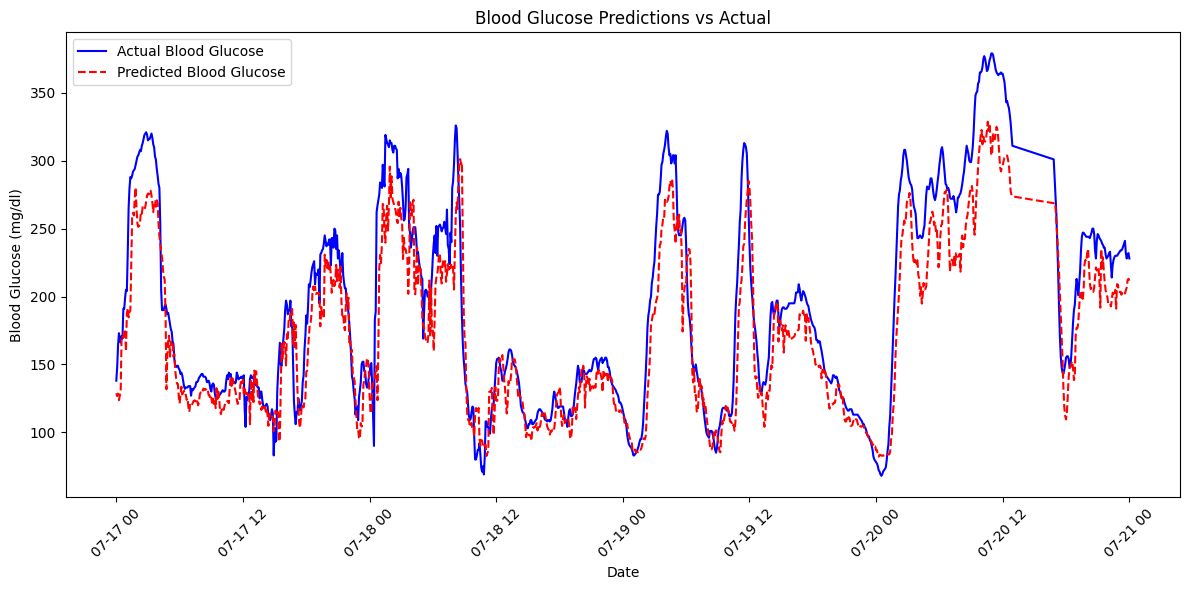

In [42]:
# Plot actual vs predicted for a specific week
def plot_predictions_for_week(data, predictions, actual, start_date, end_date):
    # Filter the test data for the specified week
    week_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)].reset_index(drop=True)

    # Get aligned predictions and actual values
    aligned_predictions = predictions[:len(week_data)]
    aligned_actual = actual[:len(week_data)]

    # Plot actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(week_data['date'], aligned_actual, label='Actual Blood Glucose', color='blue')
    plt.plot(week_data['date'], aligned_predictions, label='Predicted Blood Glucose', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Blood Glucose (mg/dl)')
    plt.title('Blood Glucose Predictions vs Actual')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot for a specific week
plot_predictions_for_week(merged_data[train_size:], predictions, y_test, '2021-07-17', '2021-07-21')

6

In [43]:
# Create labels for prediction (15 minutes into the future)
forecast_horizon = 6  # 15 minutes (3 readings ahead assuming 5-min intervals)
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN due to target shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Split into features and labels
features = [f'lag_{i}' for i in range(1, num_lags + 1)] + \
           [f'{var}_lag_{i}' for var in bolus_vars for i in range(1, num_lags + 1)]
X = merged_data[features].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for CNN (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [44]:
# Build CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 142s 16ms/step - loss: 2917.2744 - mae: 38.0226 - val_loss: 1183.9271 - val_mae: 25.3214
Epoch 2/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 131s 15ms/step - loss: 1461.3979 - mae: 28.3372 - val_loss: 1060.4624 - val_mae: 23.6376
Epoch 3/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 145s 15ms/step - loss: 1406.0312 - mae: 27.8530 - val_loss: 1027.2593 - val_mae: 23.3862
Epoch 4/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 134s 15ms/step - loss: 1390.1060 - mae: 27.6177 - val_loss: 994.8427 - val_mae: 22.8544
Epoch 5/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 132s 15ms/step - loss: 1376.2350 - mae: 27.4479 - val_loss: 1193.2747 - val_mae: 25.5609
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 2789.3418 - mae: 29.4121
Test Loss: 8713.650390625, Test MAE: 47.88486099243164
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step
Root Mean Squared Error (RMSE): 93.3469213500036


9

In [45]:
# Create labels for prediction (15 minutes into the future)
forecast_horizon = 9  # 15 minutes (3 readings ahead assuming 5-min intervals)
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN due to target shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Split into features and labels
features = [f'lag_{i}' for i in range(1, num_lags + 1)] + \
           [f'{var}_lag_{i}' for var in bolus_vars for i in range(1, num_lags + 1)]
X = merged_data[features].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for CNN (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [46]:
# Build CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 145s 16ms/step - loss: 3453.9524 - mae: 42.6606 - val_loss: 1755.7145 - val_mae: 31.0000
Epoch 2/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 136s 15ms/step - loss: 1974.0823 - mae: 33.4059 - val_loss: 1607.6798 - val_mae: 29.3143
Epoch 3/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 141s 15ms/step - loss: 1924.0049 - mae: 32.9656 - val_loss: 1614.4214 - val_mae: 29.5758
Epoch 4/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 143s 15ms/step - loss: 1880.7372 - mae: 32.5194 - val_loss: 1739.7987 - val_mae: 30.6027
Epoch 5/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 141s 15ms/step - loss: 1866.1290 - mae: 32.3810 - val_loss: 1760.3007 - val_mae: 31.2498
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 4699.5269 - mae: 36.8702
Test Loss: 15420.5244140625, Test MAE: 62.22701644897461
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step
Root Mean Squared Error (RMSE): 124.17942624862141


12

In [47]:
# Create labels for prediction (15 minutes into the future)
forecast_horizon = 12  # 15 minutes (3 readings ahead assuming 5-min intervals)
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN due to target shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Split into features and labels
features = [f'lag_{i}' for i in range(1, num_lags + 1)] + \
           [f'{var}_lag_{i}' for var in bolus_vars for i in range(1, num_lags + 1)]
X = merged_data[features].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for CNN (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [48]:
# Build CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 136s 15ms/step - loss: 3926.4753 - mae: 46.7088 - val_loss: 2614.8906 - val_mae: 39.1737
Epoch 2/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 128s 14ms/step - loss: 2567.6931 - mae: 38.6778 - val_loss: 2442.1792 - val_mae: 37.2896
Epoch 3/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 148s 15ms/step - loss: 2486.8894 - mae: 37.9690 - val_loss: 2308.9236 - val_mae: 36.3790
Epoch 4/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 137s 15ms/step - loss: 2431.6011 - mae: 37.5528 - val_loss: 2270.9536 - val_mae: 35.6815
Epoch 5/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 147s 15ms/step - loss: 2403.0535 - mae: 37.2088 - val_loss: 2182.5591 - val_mae: 35.2106
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 7670.4502 - mae: 43.3106
Test Loss: 27576.8984375, Test MAE: 78.65147399902344
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step
Root Mean Squared Error (RMSE): 166.06297381569047


CRNN

In [49]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM, TimeDistributed
import matplotlib.pyplot as plt

# Load CGM data
file_path = '/content/drive/My Drive/Thesis/Subject1.xlsx'
cgm_data = pd.read_excel(file_path, sheet_name='CGM')

# Preprocess CGM data - Round to nearest 5 minutes and filter
cgm_data['date'] = pd.to_datetime(cgm_data['date']).dt.round('5min')
cgm_data = cgm_data[cgm_data['mg/dl'] <= 400].dropna(subset=['mg/dl'])
cgm_data = cgm_data.drop_duplicates(subset='date').sort_values(by='date').reset_index(drop=True)

# Generate lag features for CGM data
num_lags = 12  # Using the past 12 readings as features
for lag in range(1, num_lags + 1):
    cgm_data[f'lag_{lag}'] = cgm_data['mg/dl'].shift(lag)

# Load Bolus data
bolus_data = pd.read_excel(file_path, sheet_name='Bolus')
bolus_data['date'] = pd.to_datetime(bolus_data['date']).dt.round('5min')
bolus_data = bolus_data.fillna(0)  # Set missing values to 0

# Merge CGM and Bolus data
merged_data = pd.merge(cgm_data, bolus_data, on='date', how='left').fillna(0)

# Generate lag features for Bolus variables
bolus_vars = ['normal', 'carbInput', 'insulinCarbRatio', 'bgInput',
              'recommended.carb', 'recommended.net', 'recommended.correction',
              'insulinSensitivityFactor', 'targetBloodGlucose', 'insulinOnBoard']

for var in bolus_vars:
    for lag in range(1, num_lags + 1):
        merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)

# Drop rows with NaN due to shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Create labels for prediction (15 minutes into the future)
forecast_horizon = 3  # 15 minutes (3 readings ahead assuming 5-min intervals)
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN due to target shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Split into features and labels
features = [f'lag_{i}' for i in range(1, num_lags + 1)] + \
           [f'{var}_lag_{i}' for var in bolus_vars for i in range(1, num_lags + 1)]
X = merged_data[features].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for RCNN (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

<ipython-input-49-0af13503f10d>:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)
<ipython-input-49-0af13503f10d>:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)
<ipython-input-49-0af13503f10d>:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

In [50]:
# Build RCNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    LSTM(32, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 383s 43ms/step - loss: 7027.6709 - mae: 65.8387 - val_loss: 5124.0054 - val_mae: 58.7428
Epoch 2/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 399s 45ms/step - loss: 5055.1880 - mae: 57.8325 - val_loss: 5188.6250 - val_mae: 58.9752
Epoch 3/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 424s 43ms/step - loss: 4994.3750 - mae: 57.5015 - val_loss: 5073.8726 - val_mae: 58.5722
Epoch 4/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 385s 44ms/step - loss: 4994.9966 - mae: 57.5689 - val_loss: 5121.0991 - val_mae: 58.7325
Epoch 5/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 374s 42ms/step - loss: 4924.9326 - mae: 57.1399 - val_loss: 5082.8286 - val_mae: 58.6015
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 35s 12ms/step - loss: 4363.6919 - mae: 53.8565
Test Loss: 3869.942626953125, Test MAE: 51.0632209777832
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 31s 11ms/step
Root Mean Squared Error (RMSE): 62.208861847812656


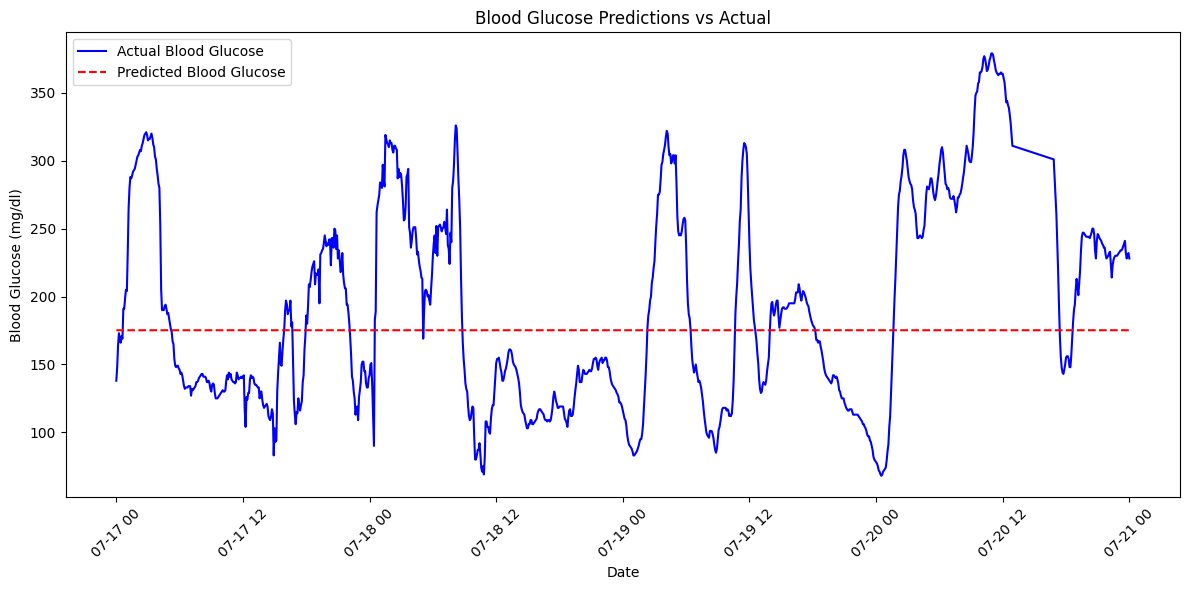

In [51]:
# Plot actual vs predicted for a specific week
def plot_predictions_for_week(data, predictions, actual, start_date, end_date):
    # Filter the test data for the specified week
    week_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)].reset_index(drop=True)

    # Get aligned predictions and actual values
    aligned_predictions = predictions[:len(week_data)]
    aligned_actual = actual[:len(week_data)]

    # Plot actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(week_data['date'], aligned_actual, label='Actual Blood Glucose', color='blue')
    plt.plot(week_data['date'], aligned_predictions, label='Predicted Blood Glucose', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Blood Glucose (mg/dl)')
    plt.title('Blood Glucose Predictions vs Actual')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot for a specific week
plot_predictions_for_week(merged_data[train_size:], predictions, y_test, '2021-07-17', '2021-07-21')